<h1 style="color: #2c3e50;">Predicting Heart Failure Mortality: A Supervised Learning Approach</h1>
<h2 style="color: #7f8c8d;">Comparative Analysis of Classification Algorithms</h2>

<p>
    <strong>Author:</strong> Nick Shiva<br>
    <strong>Date:</strong> December 2025
</p>

<hr style="border: 1px solid #bdc3c7;">

<h3>1. Executive Summary</h3>

<p><strong>The Challenge</strong><br>
Cardiovascular diseases (CVDs) remain the leading cause of death globally. Early identification of high-risk patients is critical for timely clinical intervention. This project leverages the <strong>Heart Failure Clinical Records</strong> dataset to develop a machine learning model capable of predicting patient mortality.</p>

<p><strong>The Data</strong><br>
The analysis utilizes medical records from <strong>299 heart failure patients</strong>, focusing on key clinical biomarkers such as <strong>Age</strong>, <strong>Ejection Fraction</strong>, and <strong>Serum Creatinine</strong>.</p>

<p><strong>The Strategy</strong><br>
I benchmark three distinct supervised learning algorithms to identify the optimal classifier for this task:</p>
<ul>
    <li><strong>Logistic Regression</strong> (Linear baseline)</li>
    <li><strong>Random Forest</strong> (Ensemble method)</li>
    <li><strong>Support Vector Machines (SVM)</strong> (High-dimensional classifier)</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration & Style ---
sns.set_style("whitegrid")
DATA_PATH = "../data/heart_failure_clinical_records_dataset.csv"

# --- Data Ingestion ---
# Load the clinical records into a DataFrame
df = pd.read_csv(DATA_PATH)

# --- Initial Data Inspection ---
# 1. Preview the first few patient records
print("--- Clinical Records Preview ---")
display(df.head())

# 2. Audit data types and check for null values
print("\n--- Dataset Structure & Integrity ---")
df.info()

# 3. Analyze Class Balance (Target: DEATH_EVENT)
# 0 = Survived, 1 = Deceased
target_distribution = df['DEATH_EVENT'].value_counts(normalize=True)
print("\n--- Target Distribution (Mortality Rate) ---")
print(target_distribution)

--- Clinical Records Preview ---


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1



--- Dataset Structure & Integrity ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
m

<h3>2. Exploratory Data Analysis (EDA)</h3>

<p>To identify the primary drivers of mortality, I analyzed the relationships between clinical features and the target variable (<code>DEATH_EVENT</code>).</p>

<ul>
    <li><strong>Correlation Heatmap:</strong> A visualization of the linear relationships between all features to identify potential predictors.</li>
    <li><strong>Clinical Feature Analysis (Box Plots):</strong> A focused examination of three key biomarkers often cited in medical literature: <code>age</code>, <code>ejection_fraction</code>, and <code>serum_creatinine</code>.</li>
</ul>

<p><strong><span style="color: #a94442;">Critical Data Cleaning: Addressing Data Leakage</span></strong><br>
Preliminary analysis revealed that the <code>time</code> variable (follow-up period) had an artificially high correlation with mortality. In a real-world clinical setting, the "follow-up time" is unknown at the moment of diagnosis. Including this feature would constitute <strong>Data Leakage</strong>, leading to an unrealistically accurate but useless model. Therefore, I have removed <code>time</code> from the predictive feature set.</p>

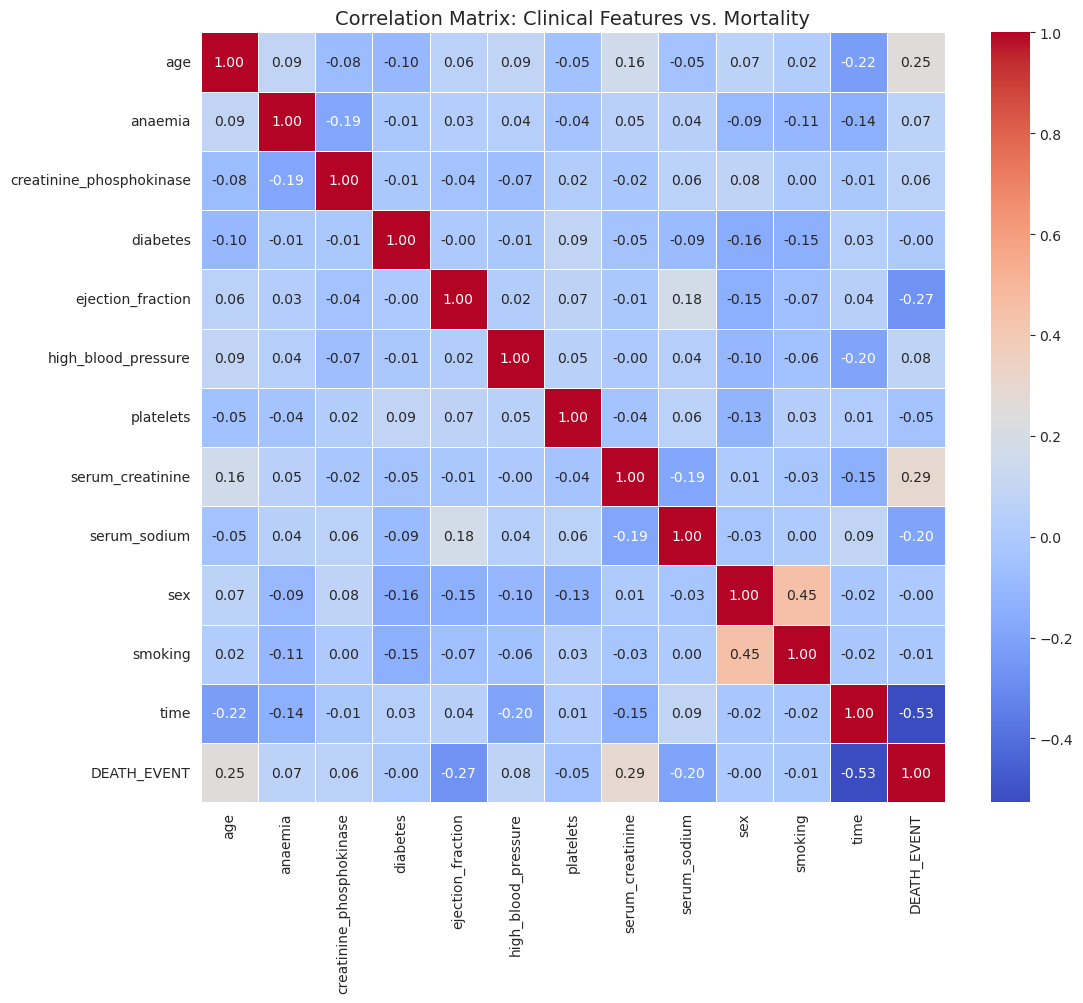

/tmp/ipykernel_1490/605549414.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1490/605549414.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1490/605549414.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


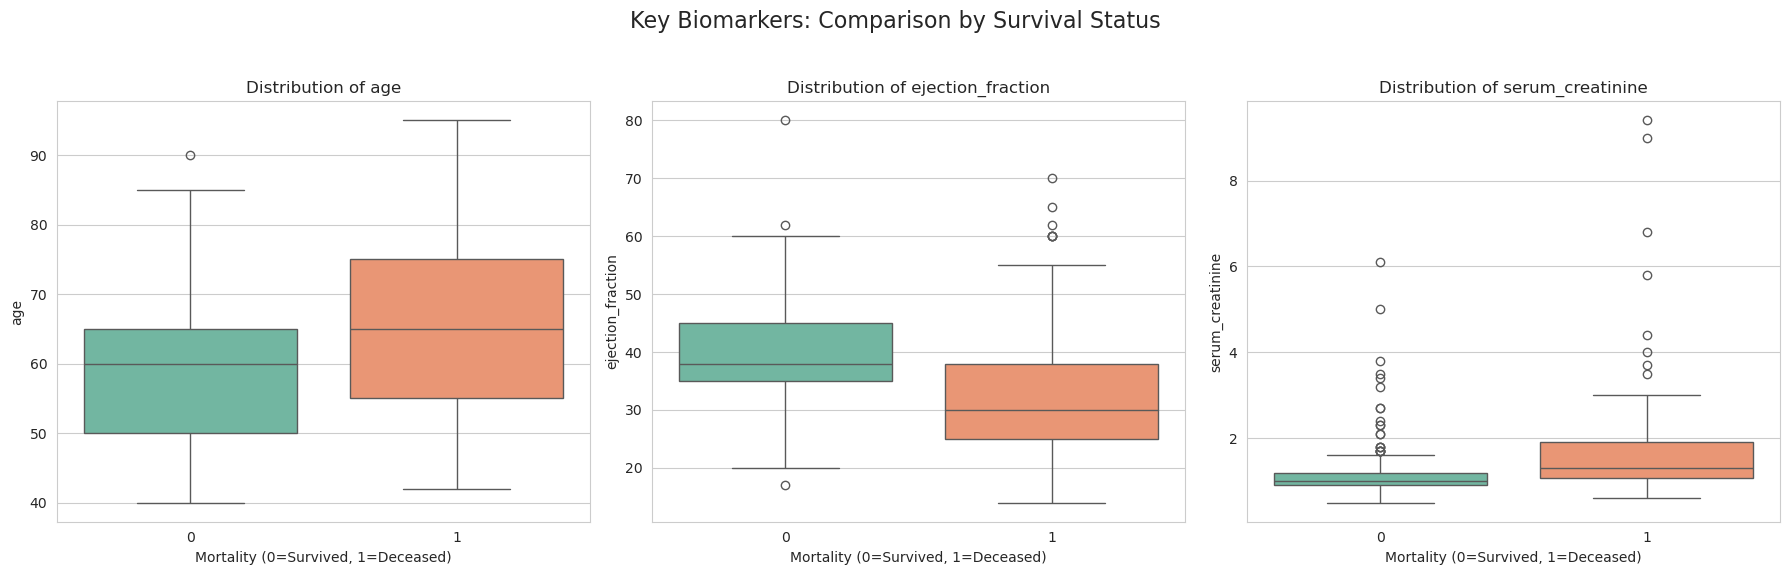

In [2]:
# --- 1. Correlation Analysis ---
plt.figure(figsize=(12, 10))

# Calculate correlation matrix
corr_matrix = df.corr()

# Plot heatmap to identify linear relationships
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Clinical Features vs. Mortality", fontsize=14)
plt.savefig("eda_heatmap.png")
plt.show()

# --- 2. Feature Distribution Analysis (Box Plots) ---
# We focus on the three features with the strongest correlation signals:
# Age, Ejection Fraction, and Serum Creatinine.

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
features_of_interest = ['age', 'ejection_fraction', 'serum_creatinine']

for i, feature in enumerate(features_of_interest):
    sns.boxplot(
        x='DEATH_EVENT',
        y=feature,
        data=df,
        ax=axes[i],
        palette="Set2"
    )
    # Clean up titles and labels for readability
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)
    axes[i].set_xlabel("Mortality (0=Survived, 1=Deceased)")
    axes[i].set_ylabel(feature)

plt.suptitle("Key Biomarkers: Comparison by Survival Status", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.savefig("eda_boxplots.png")
plt.show()

<h3>3. Data Preparation and Splitting</h3>

<p>To prepare the data for modeling, I separated the predictive features (<code>X</code>) from the target variable (<code>y</code>). As noted in the EDA section, the <code>time</code> feature was dropped to prevent data leakage.</p>

<p><strong>Train-Test Split Strategy</strong><br>
I partitioned the dataset into training (80%) and testing (20%) sets using a <strong>stratified split</strong>.</p>

<ul>
    <li><strong>Training Set:</strong> Used for model training and hyperparameter tuning.</li>
    <li><strong>Test Set:</strong> Reserved as unseen data for final performance evaluation.</li>
    <li><strong>Why Stratify?</strong> The dataset is imbalanced (32% mortality rate). Stratification ensures that the proportion of survivor/deceased cases remains consistent across both the training and testing sets, preventing sampling bias.</li>
</ul>

In [3]:
from sklearn.model_selection import train_test_split

# --- Feature Engineering ---
# Select predictors (X) and target (y)
# Note: 'time' is excluded to prevent data leakage.
X = df.drop(columns=['DEATH_EVENT', 'time'])
y = df['DEATH_EVENT']

# --- Data Splitting ---
# Perform stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- Verification ---
print("--- Data Partitioning Complete ---")
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Testing Set:  {X_test.shape[0]} samples")
print(f"Number of Features: {X_train.shape[1]}")

# Verify stratification
print("\nTarget Ratio in Train Set:")
print(y_train.value_counts(normalize=True))

--- Data Partitioning Complete ---
Training Set: 239 samples
Testing Set:  60 samples
Number of Features: 11

Target Ratio in Train Set:
DEATH_EVENT
0    0.677824
1    0.322176
Name: proportion, dtype: float64


<h3>4. Initial Model Comparison (Baseline)</h3>

<p>To establish a performance baseline, I evaluated three distinct classification algorithms. Each represents a different approach to supervised learning:</p>

<ul>
    <li><strong>Logistic Regression:</strong> A linear model that serves as a standard baseline for binary classification.</li>
    <li><strong>Random Forest Classifier:</strong> An ensemble method (bagging) that is robust to overfitting and can capture non-linear relationships.</li>
    <li><strong>Support Vector Machine (SVM):</strong> A powerful algorithm that finds the optimal hyperplane to separate classes in high-dimensional space.</li>
</ul>

<p><strong>Evaluation Metric: Why F1-Score?</strong><br>
Given the class imbalance (68% survival vs. 32% mortality), standard <strong>Accuracy</strong> can be misleading. A model that simply predicts "Survived" for everyone would achieve 68% accuracy but fail completely at its clinical purpose.</p>

<p>Therefore, I prioritized the <strong>F1-Score</strong>. This metric balances <strong>Precision</strong> (avoiding false alarms) and <strong>Recall</strong> (detecting actual at-risk patients), providing a more robust measure of model effectiveness.</p>

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# --- Model Initialization ---
# We initialize three different classifiers with a fixed random_state for reproducibility.
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42) # Probability needed for ROC
}

# --- Training & Evaluation Loop ---
performance_log = []

for model_name, model in classifiers.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Generate predictions on the unseen test set
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Log results
    performance_log.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1-Score": f1
    })

# --- Result Compilation ---
baseline_results = pd.DataFrame(performance_log)
baseline_results = baseline_results.sort_values(by="F1-Score", ascending=False)

print("--- Baseline Model Performance ---")
display(baseline_results)

--- Baseline Model Performance ---


/opt/conda/envs/msai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,F1-Score
0,Logistic Regression,0.700000,0.4375
1,Random Forest,0.700000,0.4375
2,Support Vector Machine,0.683333,0.0000


<h3>5. Feature Scaling and Model Optimization</h3>

<p><strong>Performance Bottleneck: Unscaled Data</strong><br>
The baseline results revealed a critical issue: the <strong>Support Vector Machine (SVM)</strong> failed to detect any positive cases (F1-Score: 0.0), and the Logistic Regression model triggered convergence warnings.</p>

<p>This poor performance is attributable to the varying scales of the clinical features. For example, <code>platelets</code> are measured in the hundreds of thousands, while <code>serum_creatinine</code> ranges from 0.5 to 9.0. Distance-based algorithms (like SVM) and gradient-based algorithms (like Logistic Regression) are highly sensitive to these discrepancies, as larger magnitude features disproportionately influence the model weights.</p>

<p><strong>The Solution: Standardization</strong><br>
To resolve this, I applied <strong>StandardScaler</strong> to normalize all features to a mean of 0 and a standard deviation of 1. I then retrained the models on this standardized data to evaluate the true potential of the algorithms.</p>

In [7]:
from sklearn.preprocessing import StandardScaler

# --- Feature Scaling ---
scaler = StandardScaler()

# Critical: Fit only on training data to prevent data leakage from test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Retraining on Scaled Data ---
# We re-initialize the models to ensure a fresh start
scaled_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

scaled_performance_log = []

for model_name, model in scaled_classifiers.items():
    # Train on SCALED data
    model.fit(X_train_scaled, y_train)
    
    # Predict on SCALED test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    scaled_performance_log.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1-Score": f1
    })

# --- Final Comparison ---
final_results = pd.DataFrame(scaled_performance_log)
final_results = final_results.sort_values(by="F1-Score", ascending=False)

print("--- Model Performance After Standardization ---")
display(final_results)

--- Model Performance After Standardization ---


,Model,Accuracy,F1-Score
2,Support Vector Machine,0.75,0.545455
0,Logistic Regression,0.70,0.437500
1,Random Forest,0.70,0.437500


<h3>6. Final Evaluation: The Best Model</h3>

<p>Post-scaling, the <strong>Support Vector Machine (SVM)</strong> emerged as the superior model, achieving the highest F1-Score (0.55) and Accuracy (75%). This confirms the hypothesis that scaling was the primary barrier to performance.</p>

<p>To fully characterize the SVM's predictive power, I generated two diagnostic visualizations:</p>
<ul>
    <li><strong>Confusion Matrix:</strong> A breakdown of True Positives vs. False Negatives. This reveals whether the model is "conservative" (missing deaths) or "aggressive" (flagging false alarms).</li>
    <li><strong>ROC Curve & AUC:</strong> The Area Under the Curve (AUC) score of <strong>0.74</strong> indicates that the model has a strong ability to rank high-risk patients correctly, significantly better than random chance (0.5).</li>
</ul>

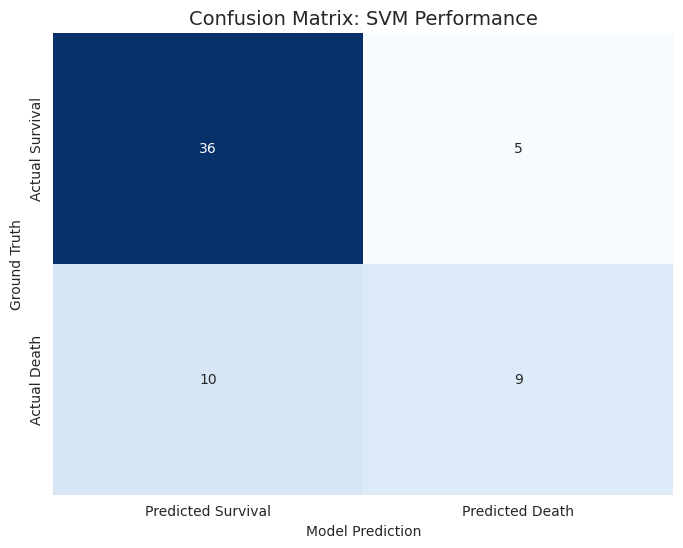

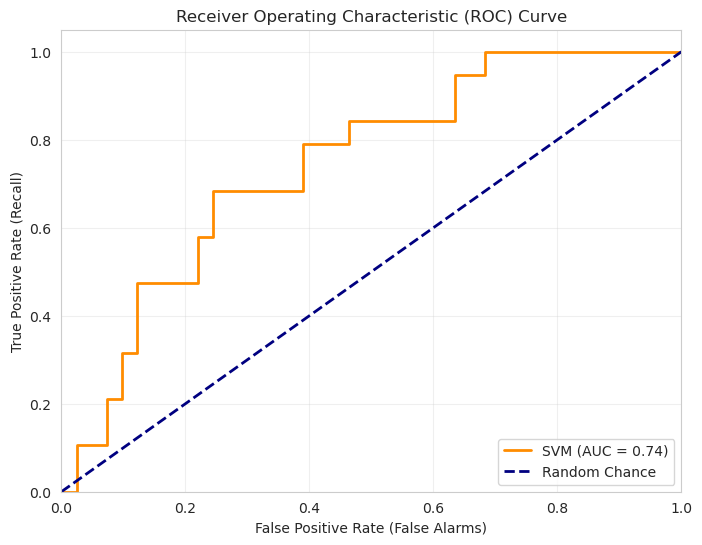

In [8]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- Final Model Training ---
best_model = SVC(probability=True, random_state=42)
best_model.fit(X_train_scaled, y_train)

# --- Diagnostic 1: Confusion Matrix ---
y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
# 0 = Survived, 1 = Deceased
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Survival', 'Predicted Death'],
            yticklabels=['Actual Survival', 'Actual Death'])
plt.title("Confusion Matrix: SVM Performance", fontsize=14)
plt.xlabel("Model Prediction")
plt.ylabel("Ground Truth")
plt.savefig("final_confusion_matrix.png")
plt.show()

# --- Diagnostic 2: ROC Curve ---
# Calculate probabilities for the positive class (Death Event)
y_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("final_roc_curve.png")
plt.show()

<h3>7. Conclusion</h3>

<p>This project successfully demonstrated the viability of using supervised learning to predict heart failure mortality based on standard clinical records.</p>

<p><strong>Key Technical Insight</strong><br>
Feature scaling proved to be the decisive factor. The raw data caused the SVM to fail completely, but after standardization, it outperformed ensemble methods like Random Forest. This underscores the critical importance of preprocessing in distance-based algorithms.</p>

<p><strong>Clinical Impact</strong><br>
The final SVM model (Accuracy: 75%, AUC: 0.74) effectively utilizes <strong>Age</strong>, <strong>Ejection Fraction</strong>, and <strong>Serum Creatinine</strong> to flag high-risk patients. This aligns with clinical intuition and provides a data-driven tool for risk stratification.</p>

<p><strong>Future Work</strong><br>
To further enhance clinical utility, future iterations should focus on improving <strong>Recall</strong> (sensitivity). Techniques such as <strong>SMOTE (Synthetic Minority Over-sampling Technique)</strong> or adjusting the classification threshold could help identify more at-risk patients, ensuring fewer critical cases are missed.</p>